# Stage 1: LSTM Baseline — LOS / NLOS Classification
## Standard Baseline for Comparison Against DualCircuit PI-HLNN (LNN)

**Purpose**: Standard LSTM baseline — no physics priors, no FP conditioning.

**Fair comparison controls**:
- Same CIR input: Raw 60-sample CIR window (identical preprocessing)
- Same training: AdamW, cosine LR with warmup, gradient clipping, early stopping
- Same split: 70/15/15 stratified, seed=42
- Same evaluation: Accuracy, AUC, F1, confusion matrix, ROC

**Key difference**: The LNN gets FP_AMPL1/2/3 as physics-informed conditioning (tau = f(FP)). The LSTM does NOT — because LSTM has no tau/ODE dynamics to exploit FP features physically. Giving LSTM the same FP features as extra inputs would just be handing it free discriminative features, not a physics-informed integration.

| | LSTM (this notebook) | DualCircuit PI-HLNN |
|---|---|---|
| Input | CIR only (60×1) | CIR (60×1) + FP_AMPL1/2/3 conditioning |
| Recurrent unit | Standard LSTM gates | Conductance-based LTC ODE |
| Time constant | Fixed (learned bias) | Emergent τ = Cm/(g_leak + Σw·gate(v)) |
| Physics-informed | No | Yes (ODE + FP→τ coupling) |
| Pooling | Attention (64→1) | Attention (32→1) per circuit |
| Embedding dim | 64 | 64 (2×32) |
| Parameters | ~19.3k | ~17.2k |

In [11]:
CONFIG = {
    "pre_crop": 10,
    "post_crop": 50,
    "total_len": 60,
    "search_start": 740,
    "search_end": 890,
    "hidden_size": 64,
    "input_size": 1,
    "dropout": 0.2,
    "batch_size": 64,
    "max_epochs": 40,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "warmup_epochs": 3,
    "patience": 10,
    "grad_clip": 1.0,
    "val_ratio": 0.15,
    "test_ratio": 0.15,
    "seed": 42,
}

In [12]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

Device: cuda


---
## Section 2: Data Loading, ROI Alignment & 70/15/15 Split

Identical CIR preprocessing to LNN pipeline — same data, same split, same seed.
**No FP_AMPL features** — LSTM processes raw CIR only.

In [13]:
# ==========================================
# SMART ROI ALIGNMENT (identical to LNN)
# ==========================================
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


# ==========================================
# DATASET LOADER (CIR only — no FP features)
# ==========================================
def load_cir_dataset(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """Returns: X (N, 60, 1), y (N,) — no FP features for standard LSTM."""
    PRE = CONFIG["pre_crop"]
    TOTAL = CONFIG["total_len"]
    processed_seqs, labels = [], []

    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )
    print(f"  Samples: {len(df)}, CIR columns: {len(cir_cols)}")

    for _, row in df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc > 0:
            sig = sig / rxpacc

        leading_edge = get_roi_alignment(sig)
        start = max(0, leading_edge - PRE)
        end = start + TOTAL
        if end > len(sig):
            end = len(sig)
            start = max(0, end - TOTAL)
        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
        local_min, local_max = np.min(crop), np.max(crop)
        rng = local_max - local_min
        crop = (crop - local_min) / rng if rng > 0 else np.zeros(TOTAL)

        processed_seqs.append(crop)
        labels.append(float(row['Label']))

    X = np.array(processed_seqs).reshape(-1, TOTAL, 1).astype(np.float32)
    y = np.array(labels).astype(np.float32)
    print(f"  Output shape: X={X.shape}, y={y.shape}")
    print(f"  LOS: {int(np.sum(y == 0))}, NLOS: {int(np.sum(y == 1))}")
    return X, y


# Load and split 70/15/15 (same seed & stratification as LNN)
X_all, y_all = load_cir_dataset("../dataset/channels/combined_uwb_dataset.csv")

indices = np.arange(len(y_all))
idx_train, idx_temp = train_test_split(
    indices, test_size=CONFIG["val_ratio"] + CONFIG["test_ratio"],
    stratify=y_all, random_state=CONFIG["seed"]
)
idx_val, idx_test = train_test_split(
    idx_temp, test_size=CONFIG["test_ratio"] / (CONFIG["val_ratio"] + CONFIG["test_ratio"]),
    stratify=y_all[idx_temp], random_state=CONFIG["seed"]
)

X_train, y_train = X_all[idx_train], y_all[idx_train]
X_val,   y_val   = X_all[idx_val],   y_all[idx_val]
X_test,  y_test  = X_all[idx_test],  y_all[idx_test]

print(f"\nSplit (70/15/15):")
print(f"  Train: {X_train.shape[0]} (LOS: {int(np.sum(y_train==0))}, NLOS: {int(np.sum(y_train==1))})")
print(f"  Val:   {X_val.shape[0]} (LOS: {int(np.sum(y_val==0))}, NLOS: {int(np.sum(y_val==1))})")
print(f"  Test:  {X_test.shape[0]} (LOS: {int(np.sum(y_test==0))}, NLOS: {int(np.sum(y_test==1))})")

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Samples: 3600, CIR columns: 1016
  Output shape: X=(3600, 60, 1), y=(3600,)
  LOS: 1800, NLOS: 1800

Split (70/15/15):
  Train: 2520 (LOS: 1260, NLOS: 1260)
  Val:   540 (LOS: 270, NLOS: 270)
  Test:  540 (LOS: 270, NLOS: 270)


---
## Section 3: LSTM Model Architecture

**Standard LSTM** — no FP conditioning, no ODE dynamics, no physics priors.

```
CIR (60, 1)
      |
 LSTM(input=1, hidden=64)
      |
  60 hidden states
      |
 Attention Pool (64->1)
      |
   h_pooled (64-dim)
      |
 Linear(64->32)->SiLU->Dropout->Linear(32->1)->Sigmoid
```

**No FP_AMPL conditioning**: h₀ and c₀ are initialised as zeros (standard LSTM practice).

In [14]:
class LSTM_Classifier(nn.Module):
    """
    Standard LSTM baseline with attention pooling.
    No FP_AMPL conditioning — processes raw CIR only.
    """
    def __init__(self, input_size=1, hidden_size=64, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

        # Attention pooling (same mechanism as LNN)
        self.attn = nn.Linear(hidden_size, 1)

        # Classifier head (same as LNN)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, return_dynamics=False):
        batch_size = x_seq.size(0)

        # Standard zero-initialised h0/c0
        h0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)

        h_all, (h_n, c_n) = self.lstm(x_seq, (h0, c0))  # (B, 60, 64)

        # Attention pooling
        attn_w = F.softmax(self.attn(h_all).squeeze(-1), dim=1).unsqueeze(-1)
        h_pooled = (h_all * attn_w).sum(dim=1)  # (B, 64)

        pred = self.classifier(h_pooled)

        if return_dynamics:
            return pred, h_all
        return pred

    def embed(self, x_seq):
        """Return 64-dim embedding for Stage 2/3 compatibility."""
        batch_size = x_seq.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
        h_all, _ = self.lstm(x_seq, (h0, c0))
        attn_w = F.softmax(self.attn(h_all).squeeze(-1), dim=1).unsqueeze(-1)
        return (h_all * attn_w).sum(dim=1)


# Parameter count
_m = LSTM_Classifier(input_size=1, hidden_size=64)
_total = sum(p.numel() for p in _m.parameters())
print(f"LSTM_Classifier parameter count: {_total:,}")
print(f"  LSTM(1->64):          {sum(p.numel() for p in _m.lstm.parameters()):,}")
print(f"  Attention pooling:    {sum(p.numel() for p in _m.attn.parameters()):,}")
print(f"  Classifier:           {sum(p.numel() for p in _m.classifier.parameters()):,}")
print(f"  Embedding dim: {_m.hidden_size}")
print(f"\n  No FP conditioning — standard zero-init h0/c0")
del _m

LSTM_Classifier parameter count: 19,330
  LSTM(1->64):          17,152
  Attention pooling:    65
  Classifier:           2,113
  Embedding dim: 64

  No FP conditioning — standard zero-init h0/c0


---
## Section 4: Training Pipeline

Same training config as LNN: AdamW, cosine LR with warmup, early stopping.

In [15]:
# ==========================================
# TRAINING PIPELINE (matching LNN config)
# ==========================================
def train_model(X_train, y_train, X_val, y_val, config=CONFIG):
    print(f"Training on {len(X_train)} samples, validating on {len(X_val)}")
    print(f"  Input: CIR only (no FP_AMPL conditioning)")

    X_tr = torch.tensor(X_train).to(device)
    y_tr = torch.tensor(y_train).unsqueeze(1).to(device)
    X_va = torch.tensor(X_val).to(device)
    y_va = torch.tensor(y_val).unsqueeze(1).to(device)

    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

    model = LSTM_Classifier(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        dropout=config["dropout"],
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"],
                            weight_decay=config["weight_decay"])

    warmup_epochs = config["warmup_epochs"]
    total_epochs  = config["max_epochs"]

    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
        return max(0.01, 0.5 * (1.0 + math.cos(math.pi * progress)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}
    best_val_acc     = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(config["max_epochs"]):
        model.train()
        train_loss_sum = 0
        train_correct, train_total = 0, 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
            optimizer.step()
            train_loss_sum += loss.item() * len(batch_x)
            train_correct  += ((pred > 0.5).float() == batch_y).sum().item()
            train_total    += len(batch_x)

        train_loss = train_loss_sum / train_total
        train_acc  = train_correct / train_total

        model.eval()
        with torch.no_grad():
            val_pred = model(X_va)
            val_loss = criterion(val_pred, y_va)
            val_acc  = ((val_pred > 0.5).float() == y_va).float().mean().item()

        lr_now = optimizer.param_groups[0]['lr']
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss.item())
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["lr"].append(lr_now)

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc     = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 5 == 0 or epoch == config["max_epochs"] - 1:
            print(f"  Ep {epoch:>3} | Loss: {train_loss:.4f} | Val Acc: {100*val_acc:.2f}% | Best: {100*best_val_acc:.2f}% | LR: {lr_now:.1e}")

        if patience_counter >= config["patience"]:
            print(f"  Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_model_state)
    print(f"\nBest Validation Accuracy: {100*best_val_acc:.2f}%")
    return model, (X_va, y_va), history


best_model, best_data, best_history = train_model(X_train, y_train, X_val, y_val)

Training on 2520 samples, validating on 540
  Input: CIR only (no FP_AMPL conditioning)
  Ep   0 | Loss: 0.6942 | Val Acc: 50.00% | Best: 50.00% | LR: 3.3e-04
  Ep   5 | Loss: 0.5657 | Val Acc: 72.96% | Best: 72.96% | LR: 9.9e-04
  Ep  10 | Loss: 0.5559 | Val Acc: 70.37% | Best: 73.15% | LR: 9.1e-04
  Ep  15 | Loss: 0.5117 | Val Acc: 73.33% | Best: 77.22% | LR: 7.6e-04
  Ep  20 | Loss: 0.3477 | Val Acc: 77.04% | Best: 77.41% | LR: 5.6e-04
  Ep  25 | Loss: 0.2157 | Val Acc: 96.48% | Best: 96.48% | LR: 3.5e-04
  Ep  30 | Loss: 0.0833 | Val Acc: 98.52% | Best: 98.52% | LR: 1.7e-04
  Ep  35 | Loss: 0.0593 | Val Acc: 98.52% | Best: 98.52% | LR: 4.4e-05
  Ep  39 | Loss: 0.0545 | Val Acc: 98.89% | Best: 99.07% | LR: 1.0e-05

Best Validation Accuracy: 99.07%


---
## Section 5: Diagnostics

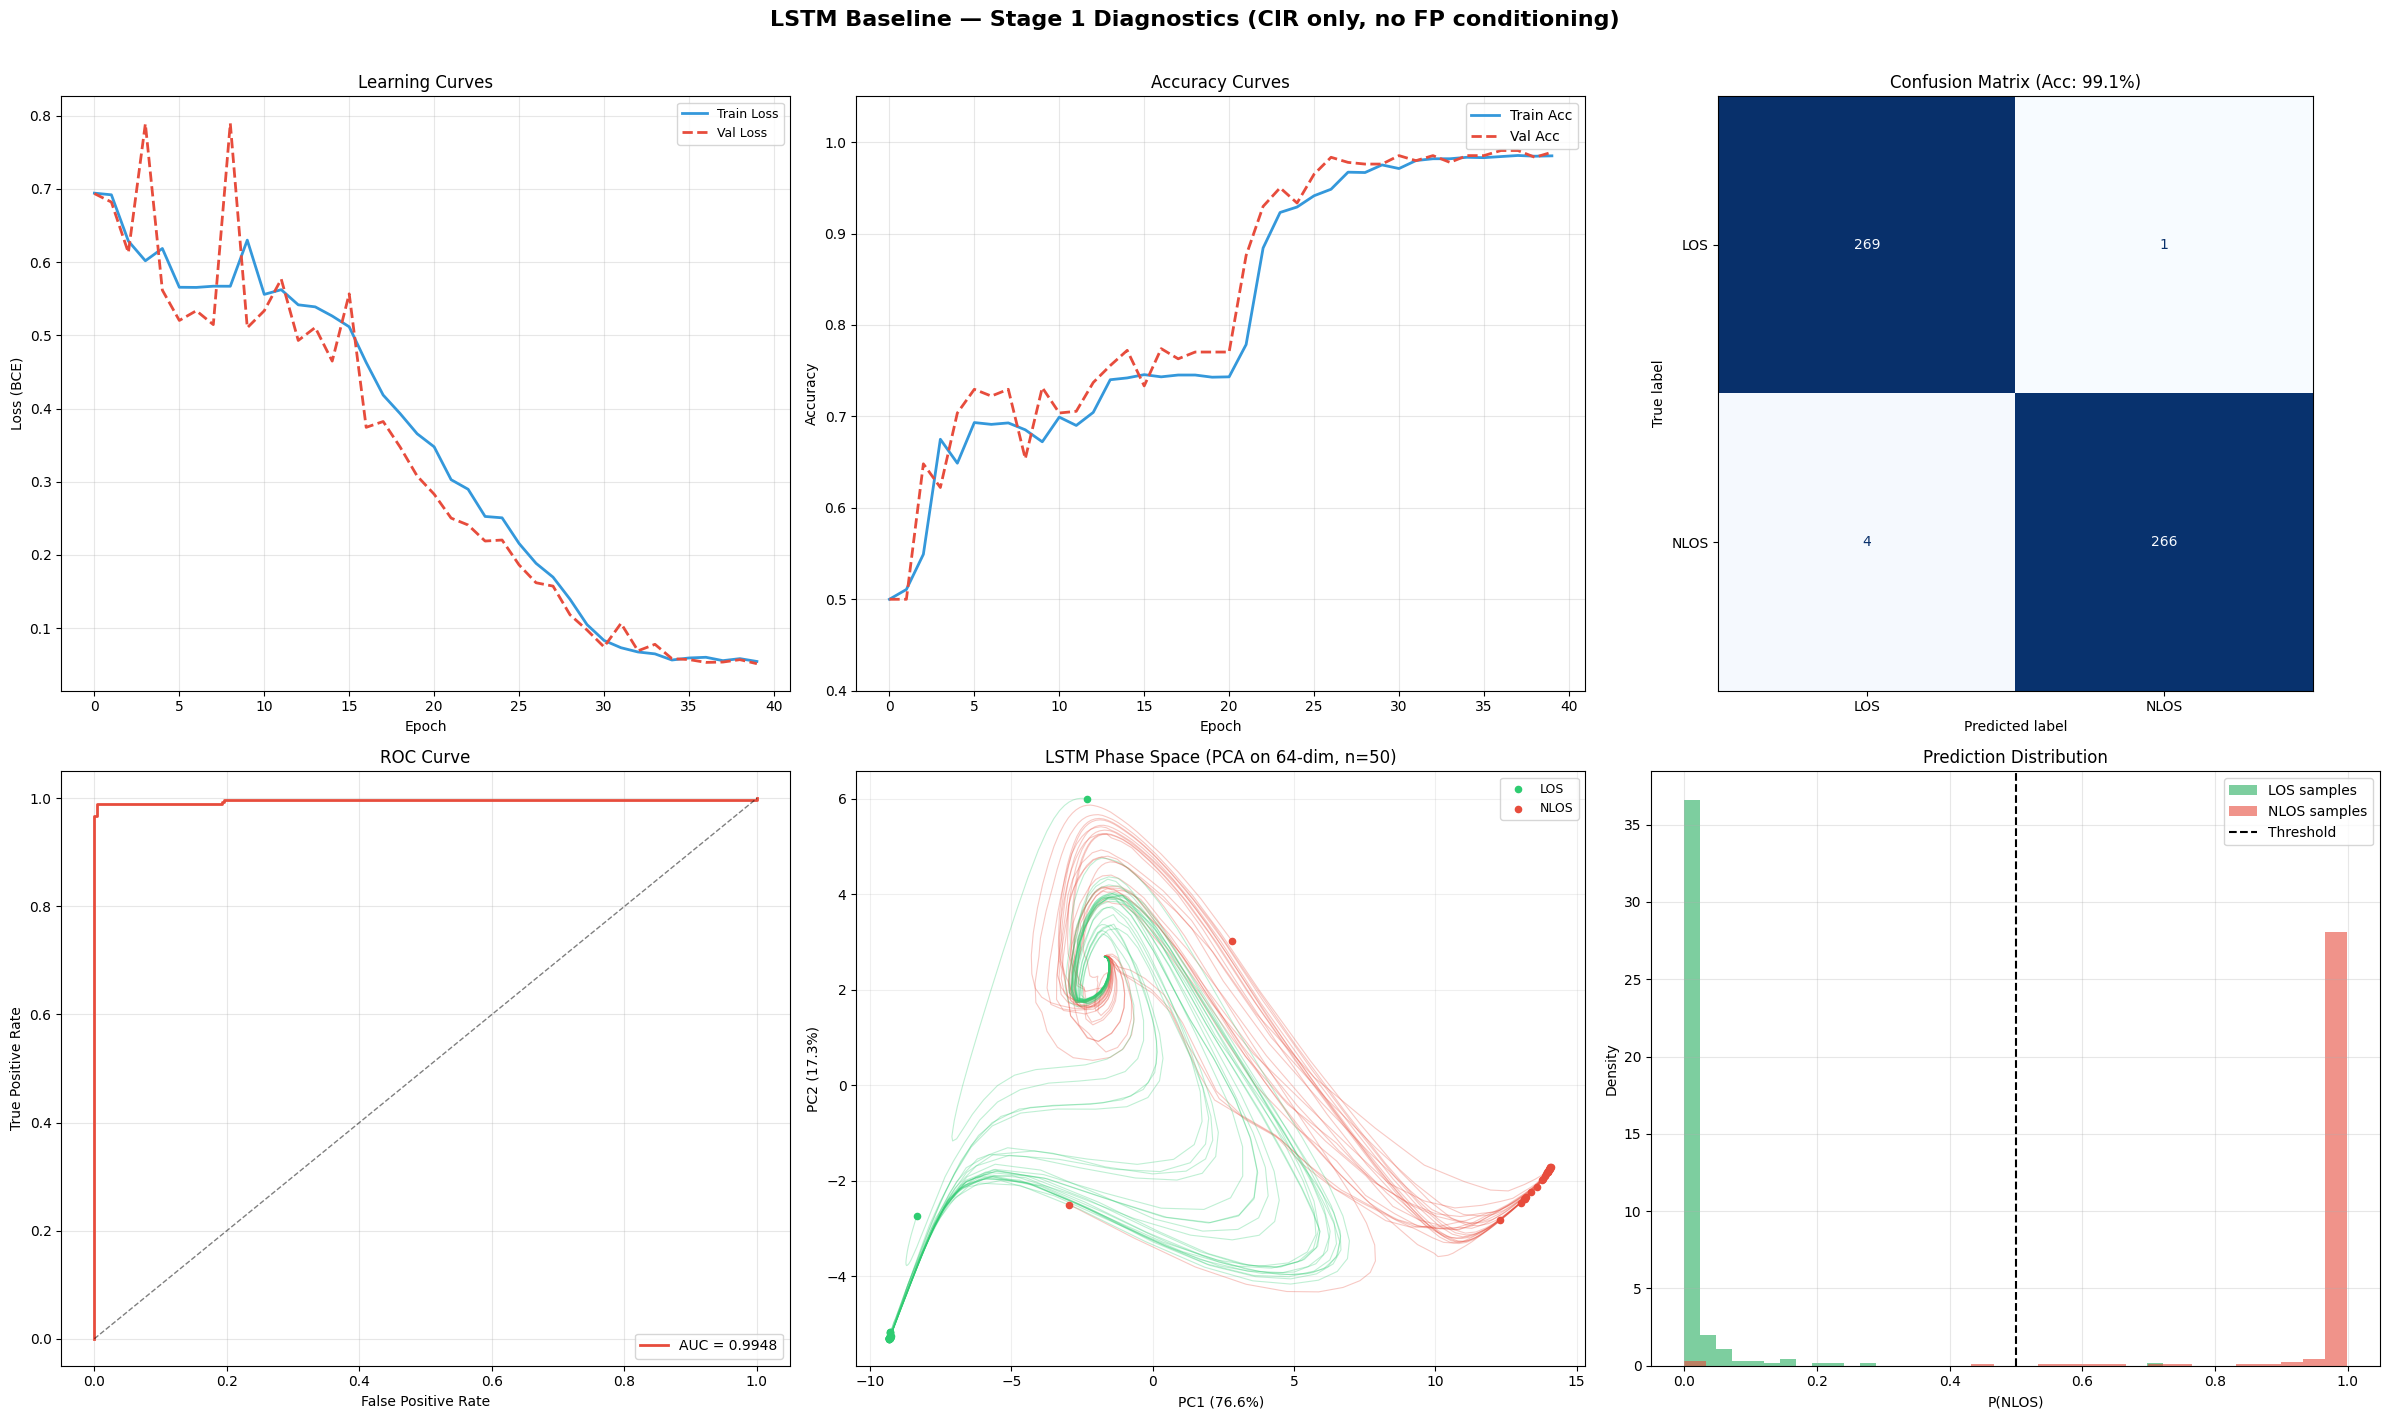

In [16]:
# ==========================================
# DIAGNOSTIC GRID (2x3) — LSTM
# ==========================================
def plot_diagnostics(model, val_data, history):
    X_va, y_va = val_data
    model.eval()

    with torch.no_grad():
        preds, h_all = model(X_va, return_dynamics=True)

    y_true = y_va.cpu().numpy().flatten()
    y_prob = preds.cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(float)
    h_hist = h_all.cpu().numpy()  # (batch, seq_len, 64)

    fig, axs = plt.subplots(2, 3, figsize=(24, 14))
    plt.subplots_adjust(hspace=0.35, wspace=0.3)

    # --- 1. LEARNING CURVES ---
    ax = axs[0, 0]
    ax.plot(history["train_loss"], label='Train Loss', color='#3498db', lw=2)
    ax.plot(history["val_loss"],   label='Val Loss',   color='#e74c3c', lw=2, ls='--')
    ax.set_title("Learning Curves")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss (BCE)")
    ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

    # --- 2. ACCURACY CURVES ---
    ax = axs[0, 1]
    ax.plot(history["train_acc"], label='Train Acc', color='#3498db', lw=2)
    ax.plot(history["val_acc"],   label='Val Acc',   color='#e74c3c', lw=2, ls='--')
    ax.set_title("Accuracy Curves")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.set_ylim([0.4, 1.05]); ax.legend(); ax.grid(True, alpha=0.3)

    # --- 3. CONFUSION MATRIX ---
    ax = axs[0, 2]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['LOS', 'NLOS'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    acc = (y_true == y_pred).mean()
    ax.set_title(f"Confusion Matrix (Acc: {100*acc:.1f}%)")

    # --- 4. ROC CURVE ---
    ax = axs[1, 0]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'AUC = {roc_auc:.4f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    ax.set_title("ROC Curve")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right'); ax.grid(True, alpha=0.3)

    # --- 5. PCA PHASE SPACE (64-dim hidden states) ---
    ax = axs[1, 1]
    batch_size, seq_len, h = h_hist.shape
    los_idx  = np.where(y_true == 0)[0]
    nlos_idx = np.where(y_true == 1)[0]
    n_show   = min(len(los_idx), len(nlos_idx), 25)
    show_idx = np.concatenate([los_idx[:n_show], nlos_idx[:n_show]])

    h_flat = h_hist.reshape(-1, h)
    scaler = StandardScaler()
    h_flat_scaled = scaler.fit_transform(h_flat)
    pca = PCA(n_components=2)
    h_pca = pca.fit_transform(h_flat_scaled).reshape(batch_size, seq_len, 2)

    nlos_show = [i for i in show_idx if y_true[i] == 1]
    los_show  = [i for i in show_idx if y_true[i] == 0]
    for i in nlos_show:
        ax.plot(h_pca[i, :, 0], h_pca[i, :, 1], color='#e74c3c', alpha=0.3, lw=0.8)
        ax.scatter(h_pca[i, -1, 0], h_pca[i, -1, 1], color='#e74c3c', s=20, zorder=5)
    for i in los_show:
        ax.plot(h_pca[i, :, 0], h_pca[i, :, 1], color='#2ecc71', alpha=0.3, lw=0.8)
        ax.scatter(h_pca[i, -1, 0], h_pca[i, -1, 1], color='#2ecc71', s=20, zorder=5)

    ax.scatter([], [], color='#2ecc71', s=20, label='LOS')
    ax.scatter([], [], color='#e74c3c', s=20, label='NLOS')
    ax.legend(fontsize=9)

    ax.set_title(f"LSTM Phase Space (PCA on 64-dim, n={n_show*2})")
    ax.set_xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)")
    ax.set_ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)")
    ax.grid(True, alpha=0.2)

    # --- 6. PREDICTION DISTRIBUTION ---
    ax = axs[1, 2]
    ax.hist(y_prob[y_true == 0], bins=30, alpha=0.6, color='#27ae60', label='LOS samples', density=True)
    ax.hist(y_prob[y_true == 1], bins=30, alpha=0.6, color='#e74c3c', label='NLOS samples', density=True)
    ax.axvline(0.5, color='black', ls='--', lw=1.5, label='Threshold')
    ax.set_title("Prediction Distribution")
    ax.set_xlabel("P(NLOS)"); ax.set_ylabel("Density")
    ax.legend(); ax.grid(True, alpha=0.3)

    plt.suptitle("LSTM Baseline — Stage 1 Diagnostics (CIR only, no FP conditioning)",
                 fontsize=16, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


plot_diagnostics(best_model, best_data, best_history)

---
## Section 6: LSTM Hidden State Temporal Evolution

LSTM has no interpretable tau — the hidden state norm is the closest analogue.

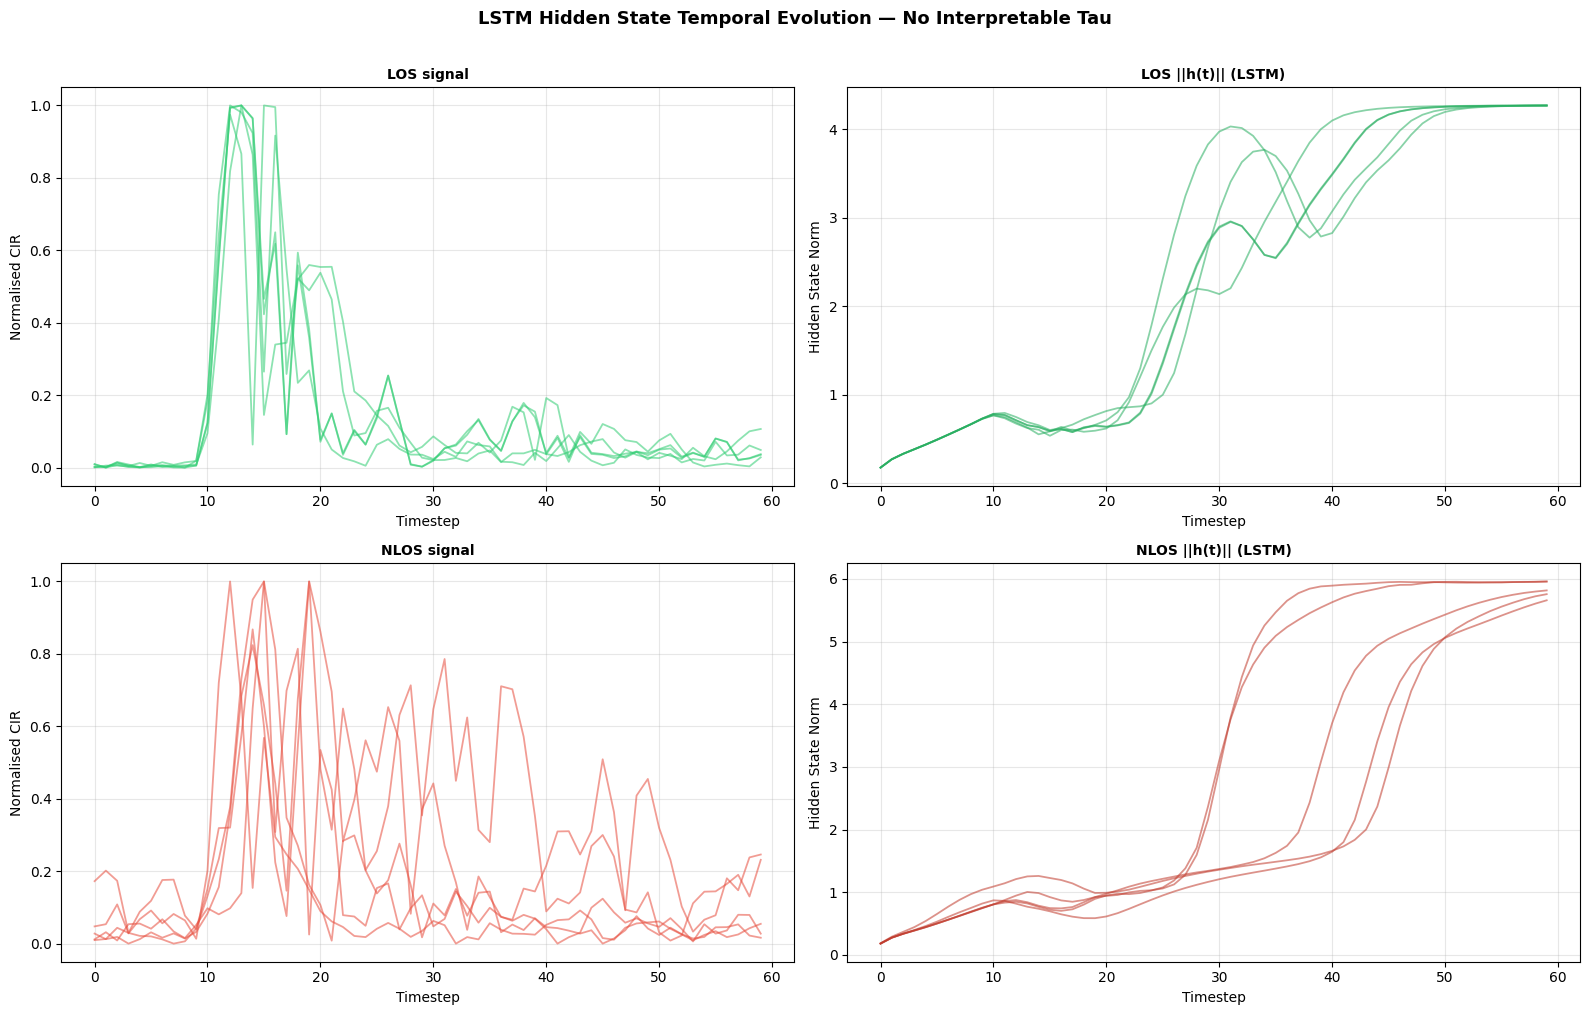

In [17]:
# ==========================================
# HIDDEN STATE TEMPORAL EVOLUTION
# ==========================================
def plot_hidden_temporal(model, val_data, n_samples=5):
    X_va, y_va = val_data
    model.eval()
    with torch.no_grad():
        _, h_all = model(X_va, return_dynamics=True)

    y_true = y_va.cpu().numpy().flatten()
    h_norm = torch.norm(h_all, dim=2).cpu().numpy()  # (batch, seq_len)
    x_input = X_va.cpu().numpy().squeeze(-1)

    los_idx  = np.where(y_true == 0)[0][:n_samples]
    nlos_idx = np.where(y_true == 1)[0][:n_samples]

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    titles = [
        ('LOS signal',              los_idx,  '#2ecc71', x_input),
        ('LOS ||h(t)|| (LSTM)',     los_idx,  '#27ae60', h_norm),
        ('NLOS signal',             nlos_idx, '#e74c3c', x_input),
        ('NLOS ||h(t)|| (LSTM)',    nlos_idx, '#c0392b', h_norm),
    ]

    for ax, (title, idx, color, data) in zip(axs.flat, titles):
        for i in idx:
            ax.plot(data[i], alpha=0.55, color=color, lw=1.3)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel("Timestep"); ax.grid(True, alpha=0.3)
        if 'signal' in title:
            ax.set_ylabel("Normalised CIR")
        else:
            ax.set_ylabel("Hidden State Norm")

    plt.suptitle("LSTM Hidden State Temporal Evolution — No Interpretable Tau",
                 fontsize=13, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


plot_hidden_temporal(best_model, best_data, n_samples=5)

---
## Section 7: Test Set Evaluation & Save Artifacts

Test Accuracy: 98.52%
Test AUC:      0.9897

Classification Report:
              precision    recall  f1-score   support

         LOS       0.98      0.99      0.99       270
        NLOS       0.99      0.98      0.99       270

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



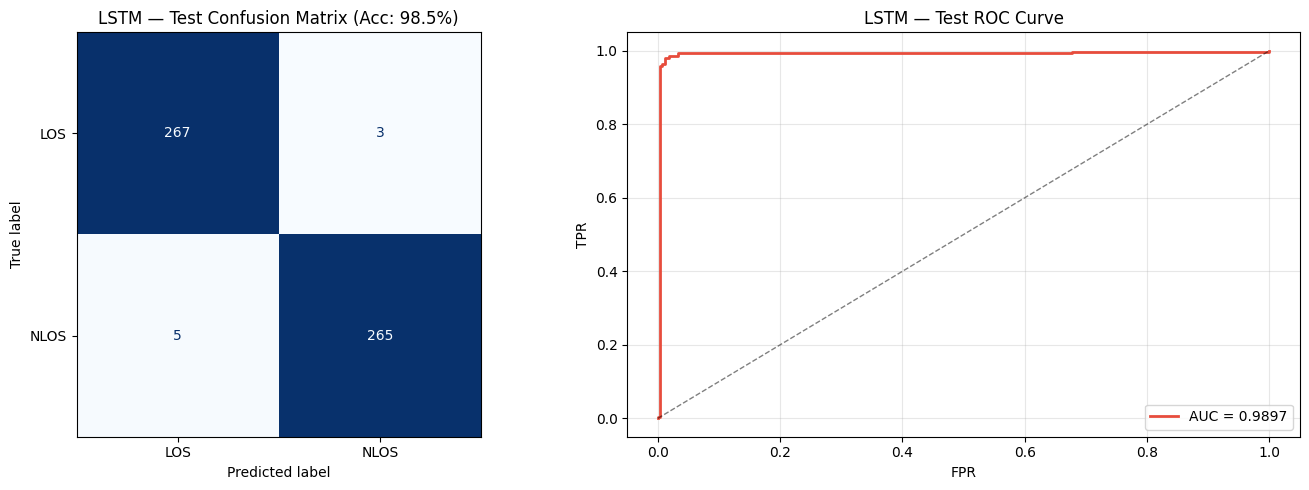


Model summary:
  Architecture: LSTM_Classifier (hidden=64)
  FP conditioning: NONE (standard zero-init)
  Embedding dim: 64
  Total params: 19,330


In [18]:
# ==========================================
# TEST SET EVALUATION
# ==========================================
best_model.eval()
X_te = torch.tensor(X_test).to(device)
y_te = torch.tensor(y_test).unsqueeze(1).to(device)

with torch.no_grad():
    test_pred = best_model(X_te)
    test_prob = test_pred.cpu().numpy().flatten()
    test_acc  = ((test_pred > 0.5).float() == y_te).float().mean().item()
    test_pred_np = (test_prob > 0.5).astype(float)
    test_true_np = y_test.flatten()

# ROC AUC
fpr, tpr, _ = roc_curve(test_true_np, test_prob)
test_auc = auc(fpr, tpr)

print(f"Test Accuracy: {100*test_acc:.2f}%")
print(f"Test AUC:      {test_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_true_np, test_pred_np, target_names=['LOS', 'NLOS']))

# Confusion matrix + ROC
cm = confusion_matrix(test_true_np, test_pred_np)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

ax = axs[0]
disp = ConfusionMatrixDisplay(cm, display_labels=['LOS', 'NLOS'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f"LSTM — Test Confusion Matrix (Acc: {100*test_acc:.1f}%)")

ax = axs[1]
ax.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'AUC = {test_auc:.4f}')
ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax.set_title("LSTM — Test ROC Curve")
ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
ax.legend(loc='lower right'); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nModel summary:")
print(f"  Architecture: LSTM_Classifier (hidden={best_model.hidden_size})")
print(f"  FP conditioning: NONE (standard zero-init)")
print(f"  Embedding dim: {best_model.hidden_size}")
print(f"  Total params: {sum(p.numel() for p in best_model.parameters()):,}")

In [19]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
torch.save(best_model.state_dict(), "stage1_lstm_best.pt")
print("Saved: stage1_lstm_best.pt")

torch.save({"config": CONFIG}, "stage1_lstm_config.pt")
print("Saved: stage1_lstm_config.pt")

print(f"\nArtifacts ready.")

Saved: stage1_lstm_best.pt
Saved: stage1_lstm_config.pt

Artifacts ready.


---
## Section 8: Summary — LSTM vs LNN Comparison

After running both notebooks, compare results:

| Metric | LSTM (CIR only) | PI-HLNN (CIR + FP) | Winner |
|--------|----------------|---------------------|--------|
| Test Accuracy | — | — | — |
| Test AUC | — | — | — |
| Test F1 (NLOS) | — | — | — |
| Convergence | ~25-35 epochs | ~4-5 epochs | LNN |
| Parameters | ~19.3k | ~17.2k | LNN (fewer) |
| Interpretable tau | No | Yes | LNN |
| Physics-informed | No | Yes (ODE + FP→tau) | LNN |

**Why no FP for LSTM?**
FP_AMPL conditioning is a **physics-informed** integration unique to the LNN:
- LNN: FP→h₀ makes tau = f(FP_AMPL) through the ODE dynamics (τ = Cm/(gleak + Σw·gate(v₀)))
- LSTM: has no tau, no ODE — FP→h₀ is just arbitrary parameter initialisation
- Giving LSTM the same FP features as free inputs would not be testing the architecture, just the features

In [20]:
print("Stage 1 LSTM baseline complete.")
print("Model artifact: stage1_lstm_best.pt")
print("Config artifact: stage1_lstm_config.pt")
print("\nCompare with LNN: capstone/lnn/stage1_pi_hlnn.ipynb")

Stage 1 LSTM baseline complete.
Model artifact: stage1_lstm_best.pt
Config artifact: stage1_lstm_config.pt

Compare with LNN: capstone/lnn/stage1_pi_hlnn.ipynb
